In [61]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path
# train_audio_path=Path(r'D:\speech recognition\greek_dataset_phylology_dept') #GREEK DATASET
train_audio_path = Path(r'D:\speech recognition\train\audio') #ENGLISH DATASET
import librosa.display
from scipy.io import wavfile
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
SAMPLE_RATE=16000

Check audio length distribution for both datasets

In [ ]:
duration_of_recordings=[]

#LOADING GREEK DATA
files = [f for f in os.listdir(str(train_audio_path)) if f.endswith('.wav')]
for wav in files:
    data,samplerate = librosa.load(str(train_audio_path) +  '\\' + wav,SAMPLE_RATE)
    duration_of_recordings.append(len(data))

#LOADING ENGLISH DATA
# for dirpath, dirnames, filenames  in (os.walk(train_audio_path)) :
#     if dirpath != os.path.join(train_audio_path, "_background_noise_" ) and  dirpath is not train_audio_path :  
#         #print(dirpath)
#         for wav in filenames:
#             if wav.endswith('.wav'):
#                 tmp_path=os.path.join(dirpath, wav)
#                 data,samplerate = librosa.load(tmp_path,SAMPLE_RATE)
#                 duration_of_recordings.append(len(data))

plt.hist(np.array(duration_of_recordings))
plt.xlabel('Audio samples length', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.title('Audio samples distribution among records')
plt.show()

Preprocessing

In [62]:
##preprocessing and feature extraction
tamikimeta=[]
# def create_df(path): #LOADING ENGLISH DATA
#     tmp_list=[]
#     for dirpath, dirnames, filenames  in (os.walk(path)) :
#         if dirpath != os.path.join(path, "_background_noise_" ) and  dirpath is not path :  
#             # print(dirpath)
#             for file in filenames:
#                 if file.endswith('.wav'):
#                     tmp_path=os.path.join(dirpath, file)
#                     class_label = tmp_path.split('\\')[-2] 
#                     tmp_list.append([tmp_path,class_label])
#                 else:
#                     continue
#     return  pd.DataFrame(tmp_list,columns=['file_path','word_label'])

def create_df(path): #LOADING GREEK DATA
    tmp_list=[]
    files = [f for f in os.listdir(str(train_audio_path)) if f.endswith('.wav')]
    for file in files:
        if file.endswith('.wav'):
            tmp_path=os.path.join(path, file)
            word_label= file.split('_')[-2]
            tmp_list.append([tmp_path,word_label])
        else:
            continue
    return  pd.DataFrame(tmp_list,columns=['file_path','word_label']) #dataframe containing the path for each word

def findmaxlength(audio_path,lengths): #FUNCTION WHICH FINDS THE TIMESERIES WITH THE MOST SAMPLES

    data,samplerate = librosa.load(audio_path,SAMPLE_RATE)
    lengths.append(len(data))
    
    return lengths

def extract_feat(data,sr): #FEATURE EXTRACTION AND STACKING TO AN ARRAY
    image_w_features = np.array([])

    mfcc = librosa.feature.mfcc(data,sr=sr,n_mfcc=13,n_fft=2048,hop_length=512).T
                    
    zcr=librosa.feature.zero_crossing_rate(data, frame_length=2048, hop_length=512, center=True).T
    
    spectral_roloff=librosa.feature.spectral_rolloff(data, sr=sr,n_fft=2048, hop_length=512,center=True).T
    
    chromagram = librosa.feature.chroma_stft(data, sr=sr, hop_length=512).T
    
    spec_bw = librosa.feature.spectral_bandwidth(y=data, sr=sr,hop_length=512,n_fft=2048, center=True).T

    image_w_features=np.hstack((mfcc,zcr))

    image_w_features=np.hstack((image_w_features,spectral_roloff))
    image_w_features=np.hstack((image_w_features,chromagram))
    image_w_features=np.hstack((image_w_features,spec_bw))
 
    return image_w_features

def get_feat_padded(audio_path,megistomikos): #ZERO PADDING FOR EQUAL LENGTH TIMESERIES

    data,samplerate = librosa.load(audio_path,SAMPLE_RATE)
    
    if len(data)<megistomikos:
        poso=int((megistomikos-len(data))/2)
        data=np.pad(data, pad_width=(poso, poso), mode='constant')
    
    #ta miki

    tamikimeta.append(len(data))
    feat = extract_feat(data,SAMPLE_RATE)
    image_feat = np.array(feat)

    return image_feat

lengths=[]
X, Y, paths = [], [], []

speech_dataframe=create_df(train_audio_path)
speech_dataframe = speech_dataframe.sample(frac = 1) #shuffling dataframe rows
# speech_dataframe=speech_dataframe.groupby('word_label').apply(lambda x: x.sample(300))
for path in speech_dataframe.file_path:
    miki= findmaxlength(path,lengths)
    
maxmikos=max(miki)
print(maxmikos)

for path, word in zip(speech_dataframe.file_path, speech_dataframe.word_label): #CREATE FEATURE AND CATEGORY VECTORS

    features=get_feat_padded(path,maxmikos)
    X.append(features)
    Y.append(word) 
    paths.append(path)

tameta=np.array(tamikimeta)        
plt.hist(tameta)

C:\Users\adrea\AppData\Local\Temp\ipykernel_20340\3585772569.py:30: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data,samplerate = librosa.load(audio_path,SAMPLE_RATE)


Counting number of records per word (for greek dataset)

In [4]:
unique, counts = np.unique(Y, return_counts=True)
count_sort_ind = np.argsort(-counts)
print(dict(zip(unique[count_sort_ind],counts[count_sort_ind])))

{'και': 2031, 'να': 1824, 'το': 1706, 'του': 1367, 'από': 778, 'δεν': 771, 'που': 647, 'ο': 601, 'στο': 578, 'την': 575, 'με': 559, 'τα': 508, 'θα': 474, 'σε': 469, 'είναι': 463, 'για': 452, 'ένα': 445, 'μου': 441, 'ναι': 440, 'τον': 422, 'της': 417, 'μία': 412, 'ήταν': 312, 'αυτό': 311, 'η': 303, 'πολύ': 295, 'ότι': 281, 'τη': 272, 'εγώ': 247, 'σου': 246, 'τι': 214, 'είχε': 205, 'στον': 190, 'έχει': 189, 'αλεπού': 182, 'μέσα': 167, 'σπιτιού': 166, 'αλλά': 164, 'σπίτι': 157, 'πηγάδι': 156, 'οι': 155, 'βοριάς': 153, 'γιατί': 149, 'τώρα': 149, 'μας': 148, 'έχω': 147, 'έτσι': 145, 'ένας': 145, 'μετά': 145, 'τους': 71}


Scaling features and encoding categorical data

In [60]:
scaler = StandardScaler()
X=np.array(X)
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
print("padded and scaled features ",X.shape)
#encoding the labels 
print("label ",Y[0])

le = LabelEncoder()
Y = to_categorical(le.fit_transform(Y)) 
print("encoded label ",Y[0])

padded and scaled bbbic (1400, 38, 28)
da label 0.6mostCommon50
da encoded label [1.]


Train,test,validation split and CNN model training

In [58]:
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
keras.backend.clear_session()

#creating test and validation set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.20)
X_validation,X_test, Y_validation,Y_test = train_test_split(X_train,Y_train,test_size=0.50)


#3D->4D array for input of CNN
print(X_train.shape,X_test.shape,X_validation.shape)
X_train=X_train[..., np.newaxis]
X_validation=X_validation[..., np.newaxis]
X_test=X_test[..., np.newaxis]

#building model
input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)
cnnModel=keras.Sequential()


cnnModel.add(keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape))
cnnModel.add(keras.layers.MaxPooling2D((3,3), strides=(2,2),padding='same'))
cnnModel.add(keras.layers.BatchNormalization())

cnnModel.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
cnnModel.add(keras.layers.MaxPooling2D((3,3), strides=(2,2),padding='same'))
cnnModel.add(keras.layers.BatchNormalization())
            
cnnModel.add(keras.layers.Conv2D(32,(2,2),activation='relu',input_shape=input_shape))
cnnModel.add(keras.layers.MaxPooling2D((2,2), strides=(2,2),padding='same'))
cnnModel.add(keras.layers.BatchNormalization())
            
             
#flatten the output and dense layers
cnnModel.add(keras.layers.Flatten())
cnnModel.add(keras.layers.Dense(64,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
cnnModel.add(keras.layers.Dropout(0.3))
#cnnModel.add(keras.layers.Dense(64,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
#cnnModel.add(keras.layers.Dropout(0.3))
             
#ouput layer
cnnModel.add(keras.layers.Dense(50,activation='softmax'))
             
optimiz = keras.optimizers.Adam(0.0001)
cnnModel.compile(optimizer=optimiz,loss="categorical_crossentropy",metrics=["accuracy"])             
cnnModel.summary()         

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', restore_best_weights=True)

historyConv=cnnModel.fit(X_train,Y_train,validation_data=(X_validation,Y_validation),callbacks=[monitor],batch_size=32,epochs=200)

test_error,test_accuracy=cnnModel.evaluate(X_test,Y_test,verbose=1)  
print("Accuracy on test set is {}".format(test_accuracy))            
print("Error on test set is {}".format(test_error))                  

(39, 28, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 37, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 13, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 19, 13, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 11, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 6, 32)         0         
 2D)                                                             
                                            

69/69 [==============================] - 0s 7ms/step - loss: 1.3431 - accuracy: 0.6195
Test accuracy: 61.9505%


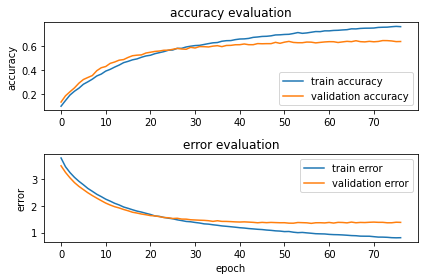

In [54]:
##accuracy and error diagrams 
score = cnnModel.evaluate(X_test,Y_test,verbose=1)
accuracy = 100*score[1]

print("Test accuracy: %.4f%%" % accuracy) 

fig,axs= plt.subplots(2)

axs[0].plot(historyConv.history["accuracy"], label="train accuracy")
axs[0].plot(historyConv.history["val_accuracy"], label="validation accuracy")
axs[0].set_ylabel("accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("accuracy evaluation")


axs[1].plot(historyConv.history["loss"], label="train error")
axs[1].plot(historyConv.history["val_loss"], label="validation error")
axs[1].set_ylabel("error")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("error evaluation")

plt.tight_layout()
plt.show()

Evaluating model accuracy for each command through confusion matrix and classification report

69/69 [==============================] - 0s 4ms/step


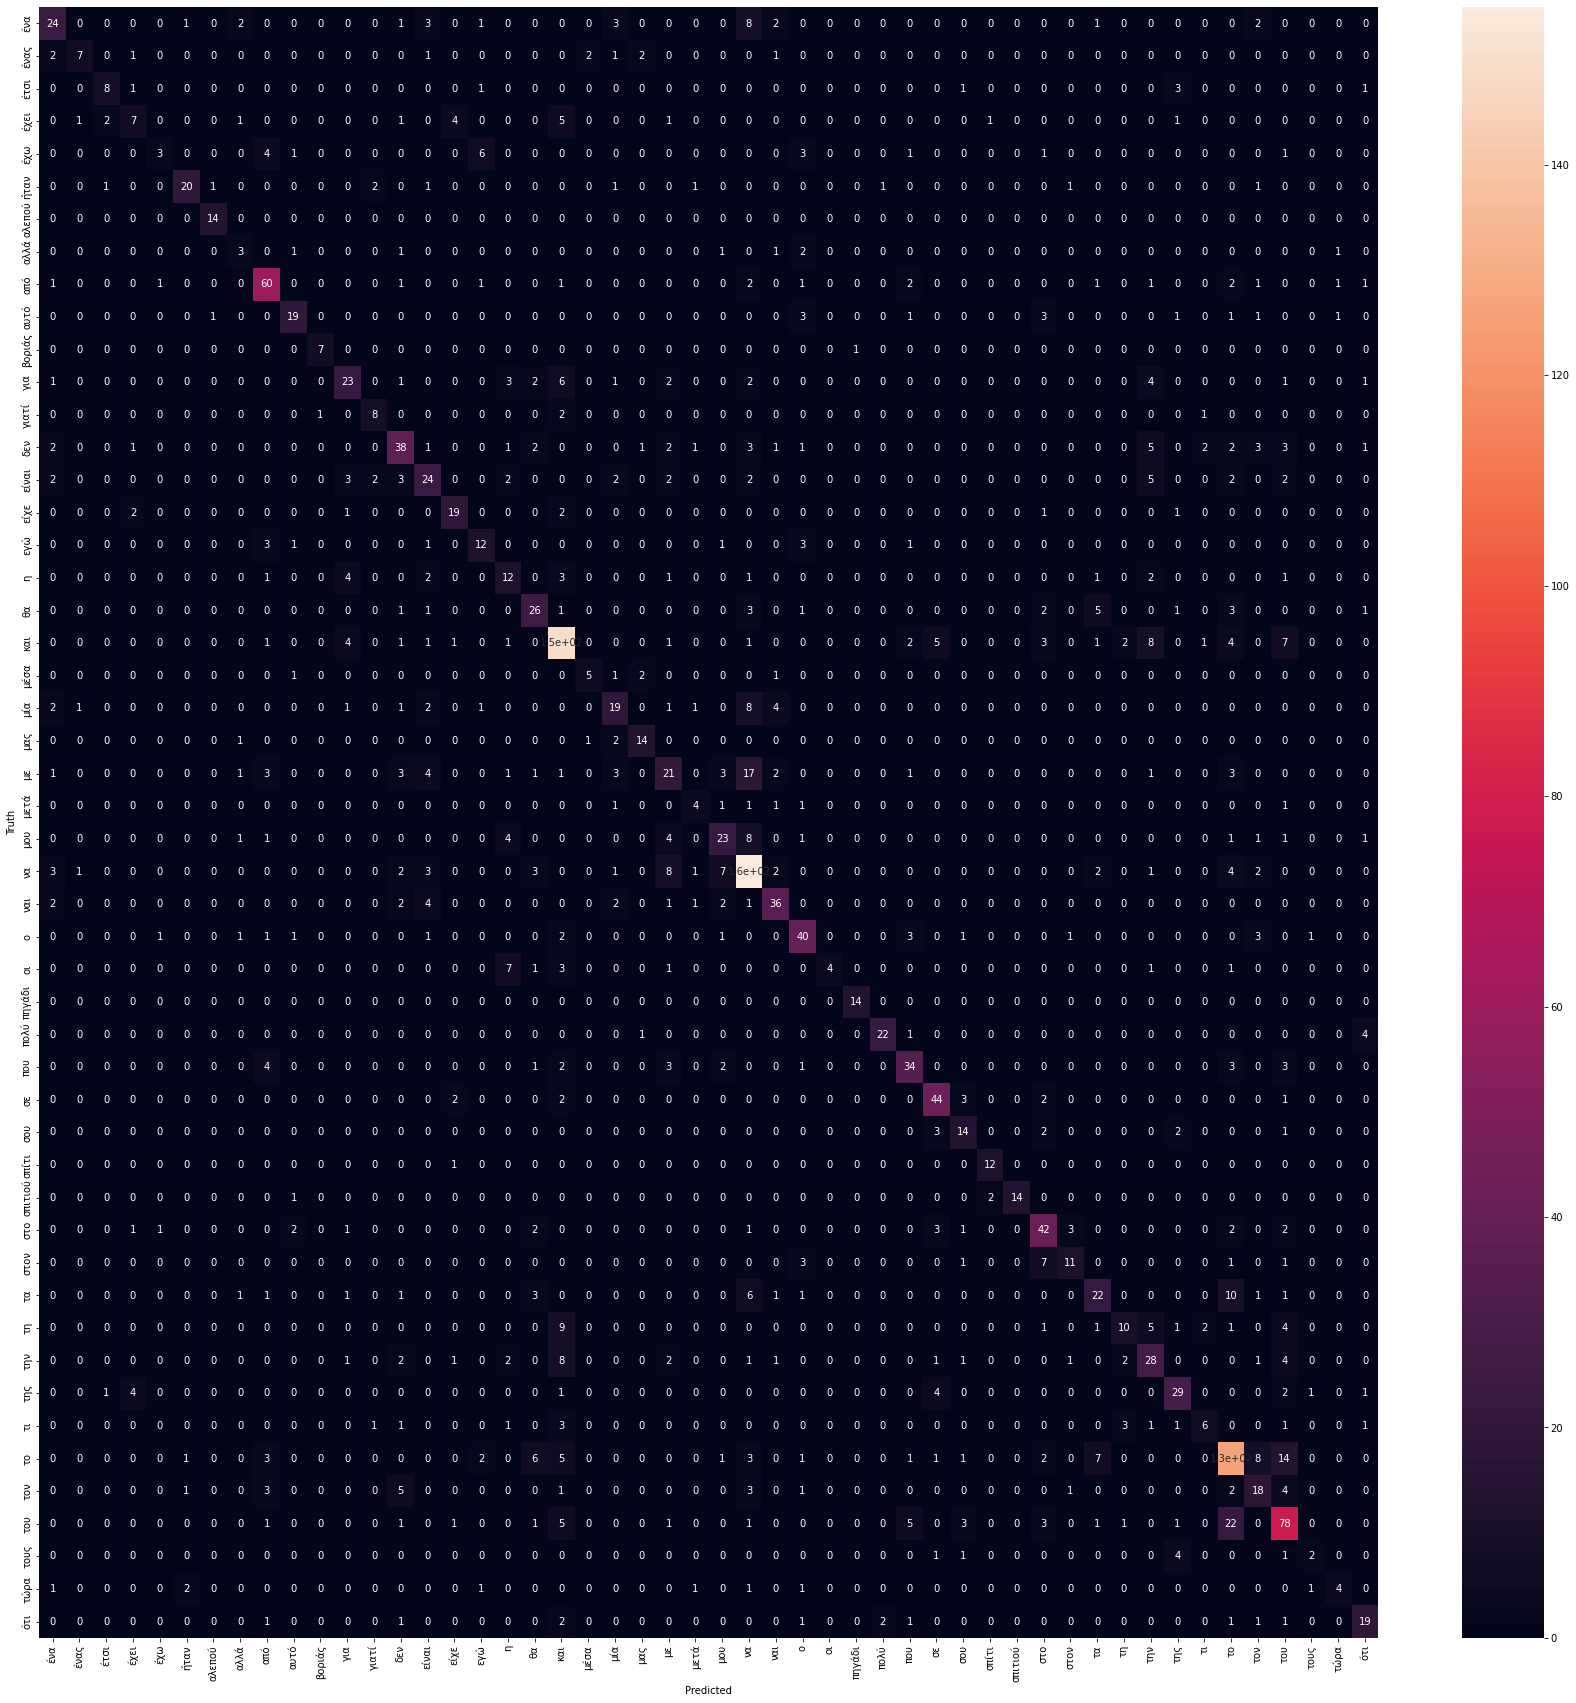

In [56]:
##confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
prediction= cnnModel.predict(X_test)
y_class1=prediction.argmax(axis=-1)

y_class2=Y_test.argmax(axis=1)
#print(y_class1)
#print(y_class2)
confMat=confusion_matrix(y_class2,y_class1)

namelist=le.classes_
newdf=pd.DataFrame(confMat,index =[i for i in namelist],columns = [i for i in namelist])
plt.figure(figsize = (30,30))
splot = sn.heatmap(newdf, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
sfig = splot.get_figure()
#sfig.savefig('confMatrix.png')

In [ ]:
from sklearn.metrics import classification_report
prediction= cnnModel.predict(X_test)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(prediction, axis=1), target_names=le.classes_))

In [13]:
cnnModel.save("greek_78ep_62testacc_1.3testloss.h5")

In [1]:
import tensorflow.keras as keras
reconstructed_model = keras.models.load_model("greek_78ep_62testacc_1.3testloss.h5")

CNN model architecture

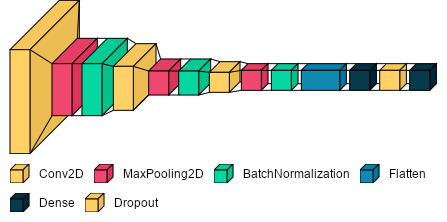

In [5]:
import visualkeras
visualkeras.layered_view(reconstructed_model, legend=True, background_fill= "white") # without custom font
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(reconstructed_model, legend=True, font=font, background_fill= "white") # selected font